In [110]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import ndimage
%matplotlib inline

In [2]:
path = os.path.expanduser('~/Data_607_Final_Project') # Your file must have the same name.
os.chdir(path) # Change this to your working directory
train = pd.read_json('~/DATA602_Final_Project/data/processed/train.json')

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

## Seperate Ships
This is important for baisic visualization to visually inspect the difference between ships and icebergs. 

In [109]:
icebergs = train[train.is_iceberg==1]
ships = train[train.is_iceberg==0]



In [40]:
from scipy import ndimage
gauss_denoised = ndimage.gaussian_filter(arr, 2)

# Denoise steps:
1. Use a de-noise algorithm like: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html
1. Correct for brighter pictures with the mean: http://yeephycho.github.io/2016/08/03/normalizations_in_neural_networks/ It may be useful to use the equalized algorithm.
1. Take the first derivative of each image: https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
1. Look at combing two bands into one image (e.g, just concatinating the strings). Maybe do this step first.
1. Set up data in a way that TF or sklearn can work with.
1. Train/Test split
1. Train Data
1. Cross Validate
1. Run on Kaggle test data

This is what the unedited images look like:

## Concatiante function:
We wanted to concatinate the images so that we could more efficently train on two different feature sets.

Below is an example of what this looks like:

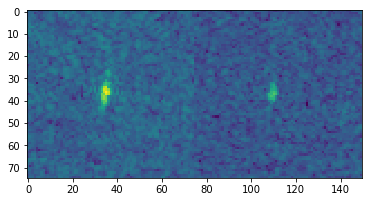

In [8]:
temp = np.concatenate((np.reshape(np.array(train.iloc[0,0]),(75,75)), 
                       np.reshape(np.array(train.iloc[0,1]),(75,75))), axis =1)
#original
imgplot = plt.imshow(temp)

## Denoise: 
This is what it looks like if we use a gaussian filter to denoise the images. Fewer lines, but less distict.
It may be worth looking at different options to denoise. 

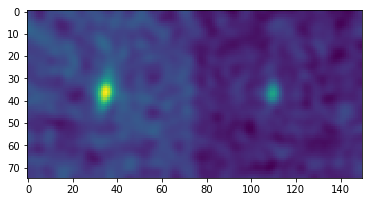

In [112]:
gauss_denoised = ndimage.gaussian_filter(temp, 2)
imgplot = plt.imshow(gauss_denoised)

## Derivatives: 

This is the code to take the first derivative of the image.

More explanation needed [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).

In [113]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
from scipy import signal
temp1 = signal.convolve2d(temp,xder,mode='valid')

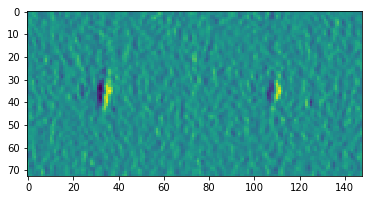

In [11]:
imgplot = plt.imshow(temp1)

Here is the code perform all the pre processing over the data frame.

It saves the results in an np array which is great for other ML libraries.

In [114]:
def pre_process(df):
    """Concatenate, gauss-denoise, first derivative"""
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(gauss_denoised, xder, mode= 'valid')
        # Append to array
        imgs.append(deriv)

    return np.array(imgs)


Xtrain = pre_process(train) # Training data
Ytrain = np.array(train['is_iceberg']) # Labels. (Data must remain in this order to not misclassify.)

# Processed image:
This image shows the transformation of gausian blur and first derivative.

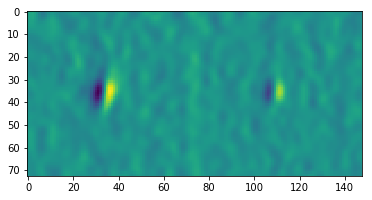

In [59]:
imgplot = plt.imshow(Xtrain[5])

In [120]:
def samplePlots(nparr, title = "Placeholder"):
    fig = plt.figure(1,figsize=(30,15))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        arr = nparr[i]
        ax.imshow(arr)
        ax.set_title(title)
    plt.show()

# Plain Edge Detection:


In [132]:
def pre_process_edge(df):
    imgs = []
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        sx = ndimage.sobel(concat, axis=0, mode='constant')
        sy = ndimage.sobel(concat, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        imgs.append(sob)
    return imgs

In [127]:
sob.shape

(73, 148)

In [131]:
sob[72].shape

(148,)

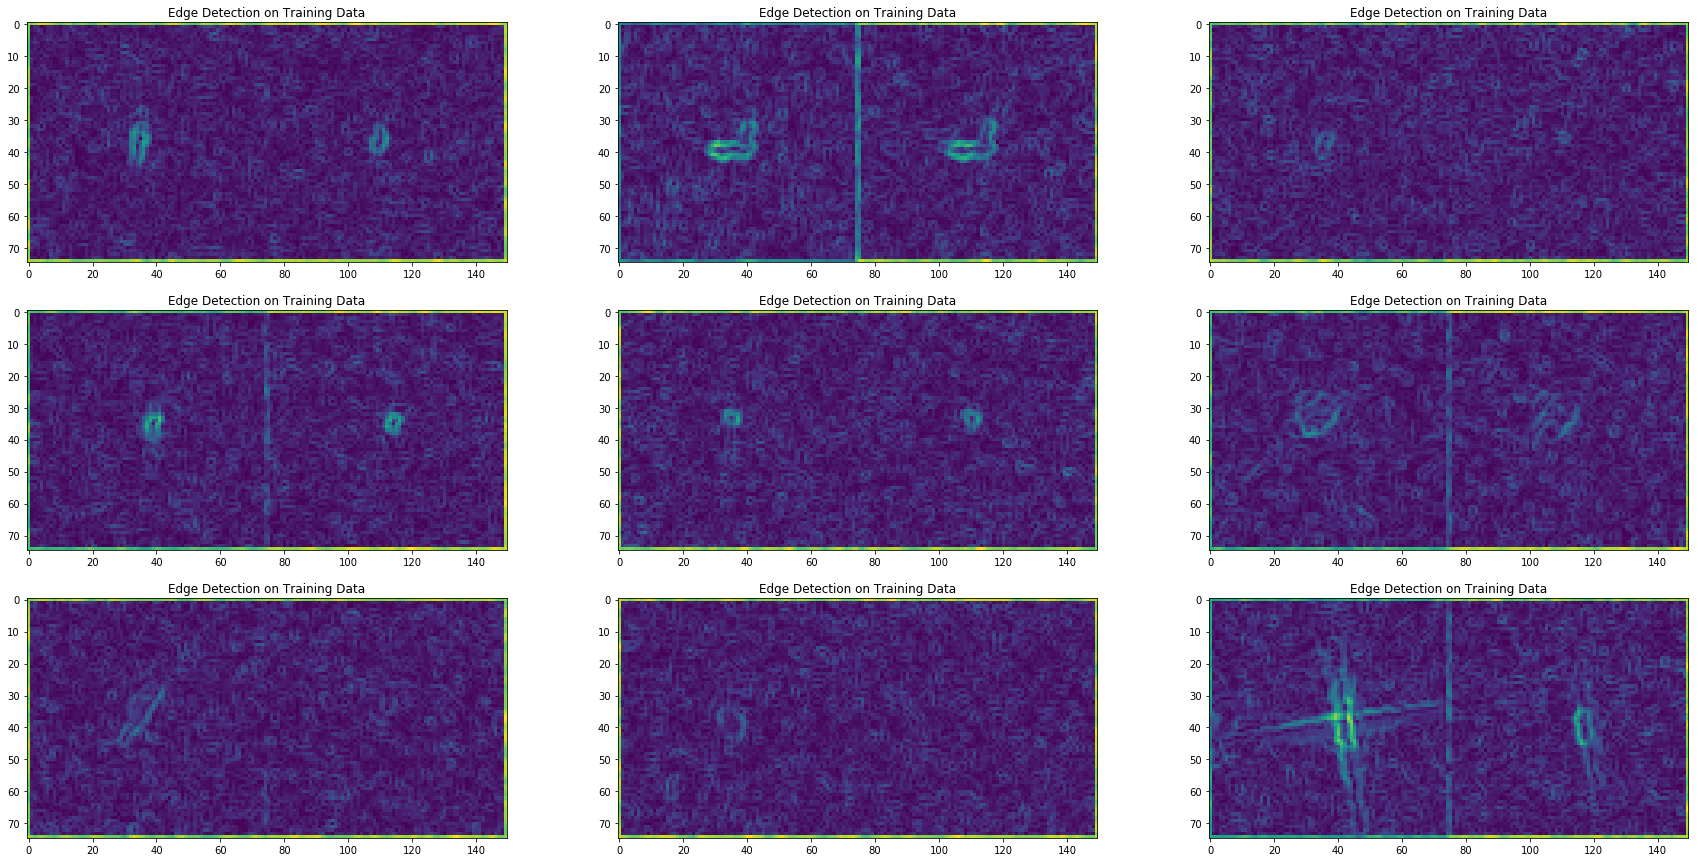

In [133]:
samplePlots(pre_process_edge(train), 'Edge Detection on Training Data')

We can see that This works well for some, but not others. 

In [96]:
arr = Xtrain[3] #np.reshape(np.array(icebergs.iloc[2,0]),(75,75))
sx = ndimage.sobel(arr, axis=0, mode='constant')
sy = ndimage.sobel(arr, axis=1, mode='constant')
sob = np.hypot(sx, sy)

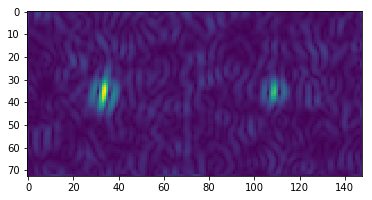

In [145]:
implot = plt.imshow(sob)

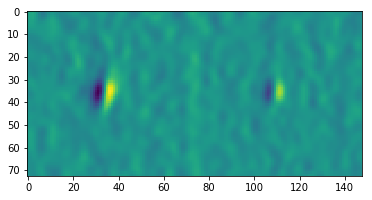

In [100]:
implot = plt.imshow(Xtrain[3])

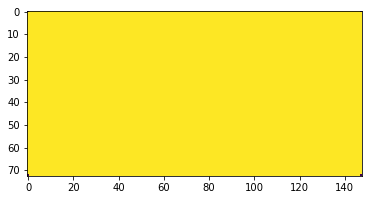

In [90]:
imgplot = plt.imshow(open_square)

In [69]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


labels = spectral_clustering(np.array(train.iloc[0,0]),(75,75), n_clusters=1, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

TypeError: spectral_clustering() got multiple values for argument 'n_clusters'

In [60]:
Xtrain[0]

array([[ 2.83655648,  4.22755992,  4.44901935, ..., -3.5214651 ,
        -3.64444425, -2.8322027 ],
       [ 2.75111622,  4.1171436 ,  4.3629311 , ..., -3.08211084,
        -2.93389695, -2.17605139],
       [ 2.65483495,  3.93598516,  4.14400678, ..., -2.69825755,
        -2.18793196, -1.44903287],
       ..., 
       [-0.30485767, -0.77436675, -0.94947973, ..., -2.98255777,
        -2.5006868 , -1.53984677],
       [-0.35450037, -0.80871598, -1.05903264, ..., -2.68128017,
        -2.10566783, -1.1804791 ],
       [-0.44937109, -0.90028411, -1.22104314, ..., -2.41818534,
        -1.73356534, -0.82850994]])

In [106]:
def pre_process_deriv(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        #gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(concat, xder, mode= 'valid')
        # Append to array
        imgs.append(deriv)

    return np.array(imgs)



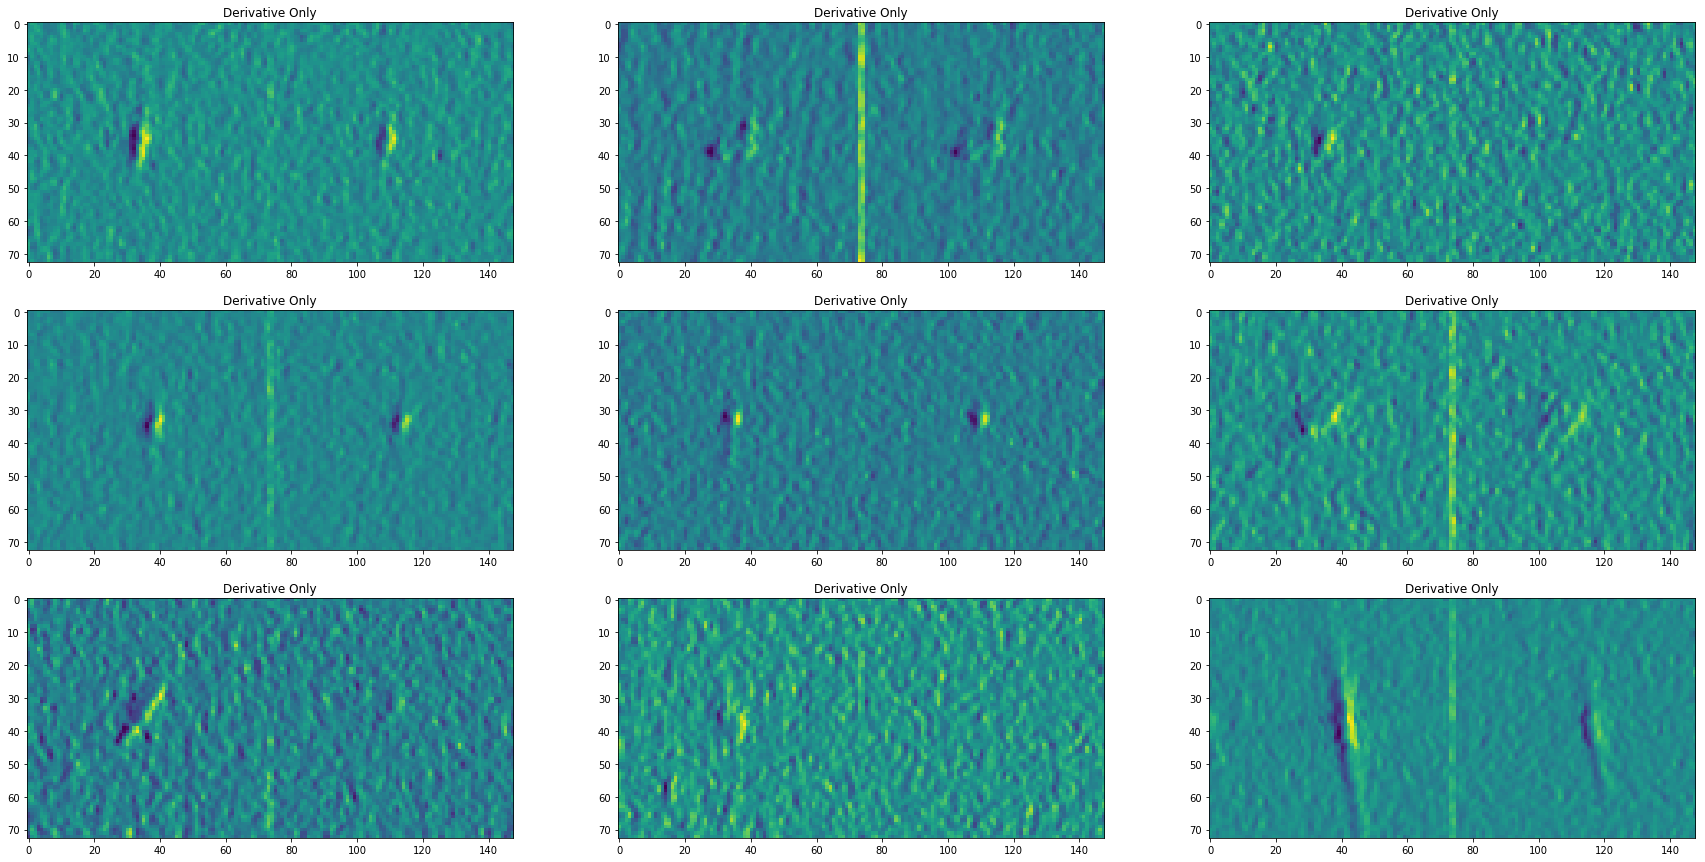

In [138]:
samplePlots(pre_process_deriv(train), "Derivative Only")

Un-processed images of icebergs:

In [143]:
def reshapedDF(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        
        # Append to array
        imgs.append(concat)

    return np.array(imgs)

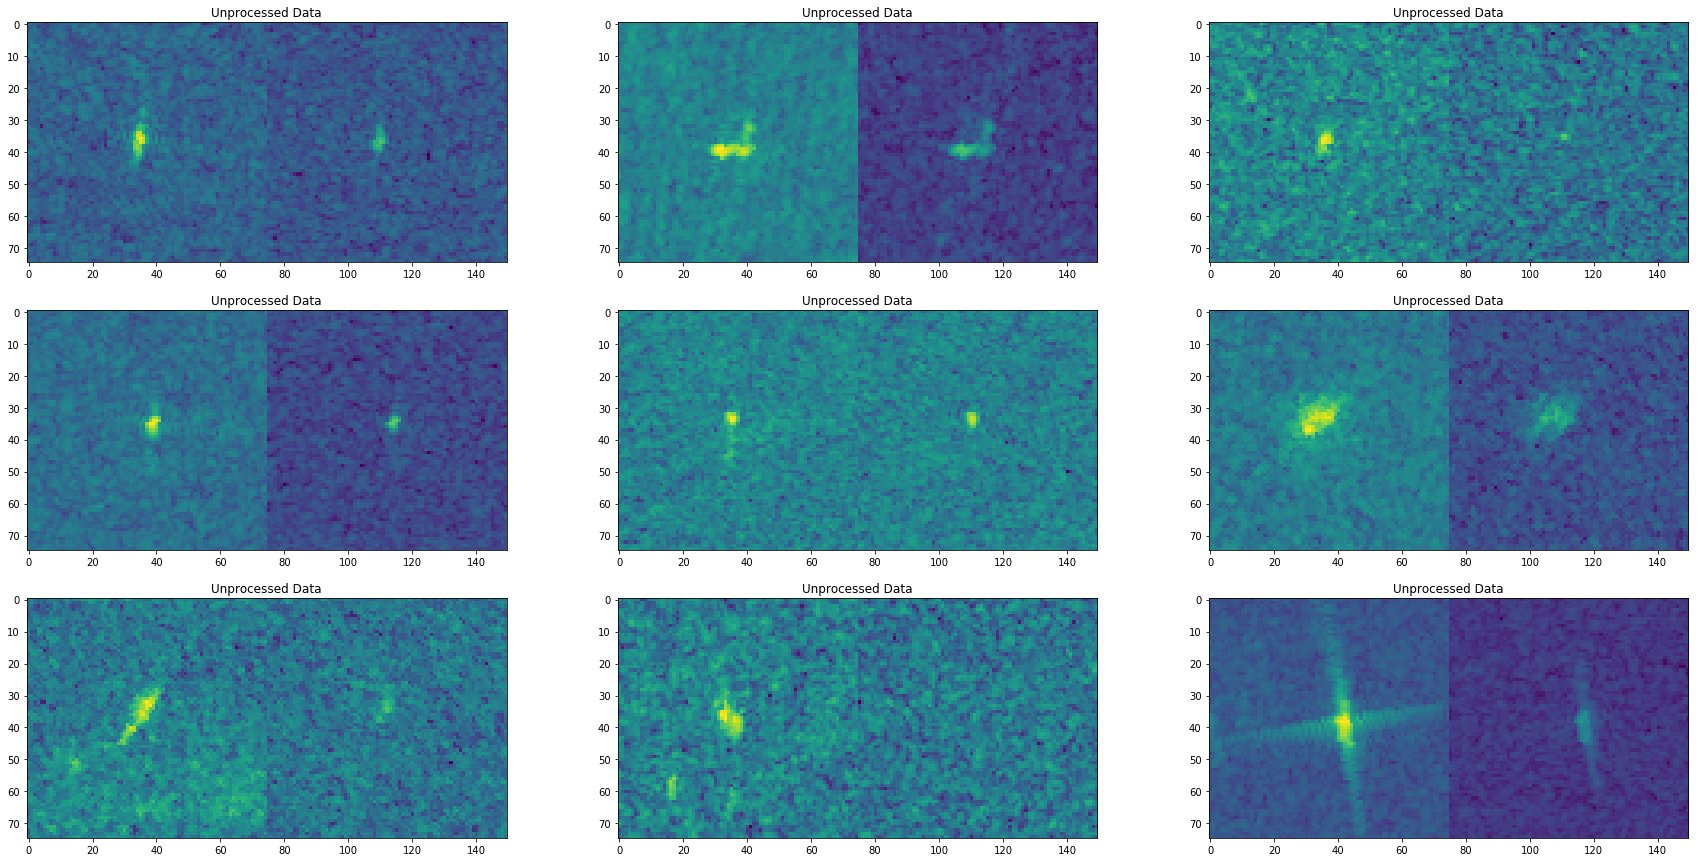

In [144]:
samplePlots(reshapedDF(train), 'Unprocessed Data')

In [146]:
def pre_process_edge_et_all(df):
    imgs = []
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(gauss_denoised, xder, mode= 'valid')
        sx = ndimage.sobel(deriv, axis=0, mode='constant')
        sy = ndimage.sobel(deriv, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        imgs.append(sob)
    return imgs

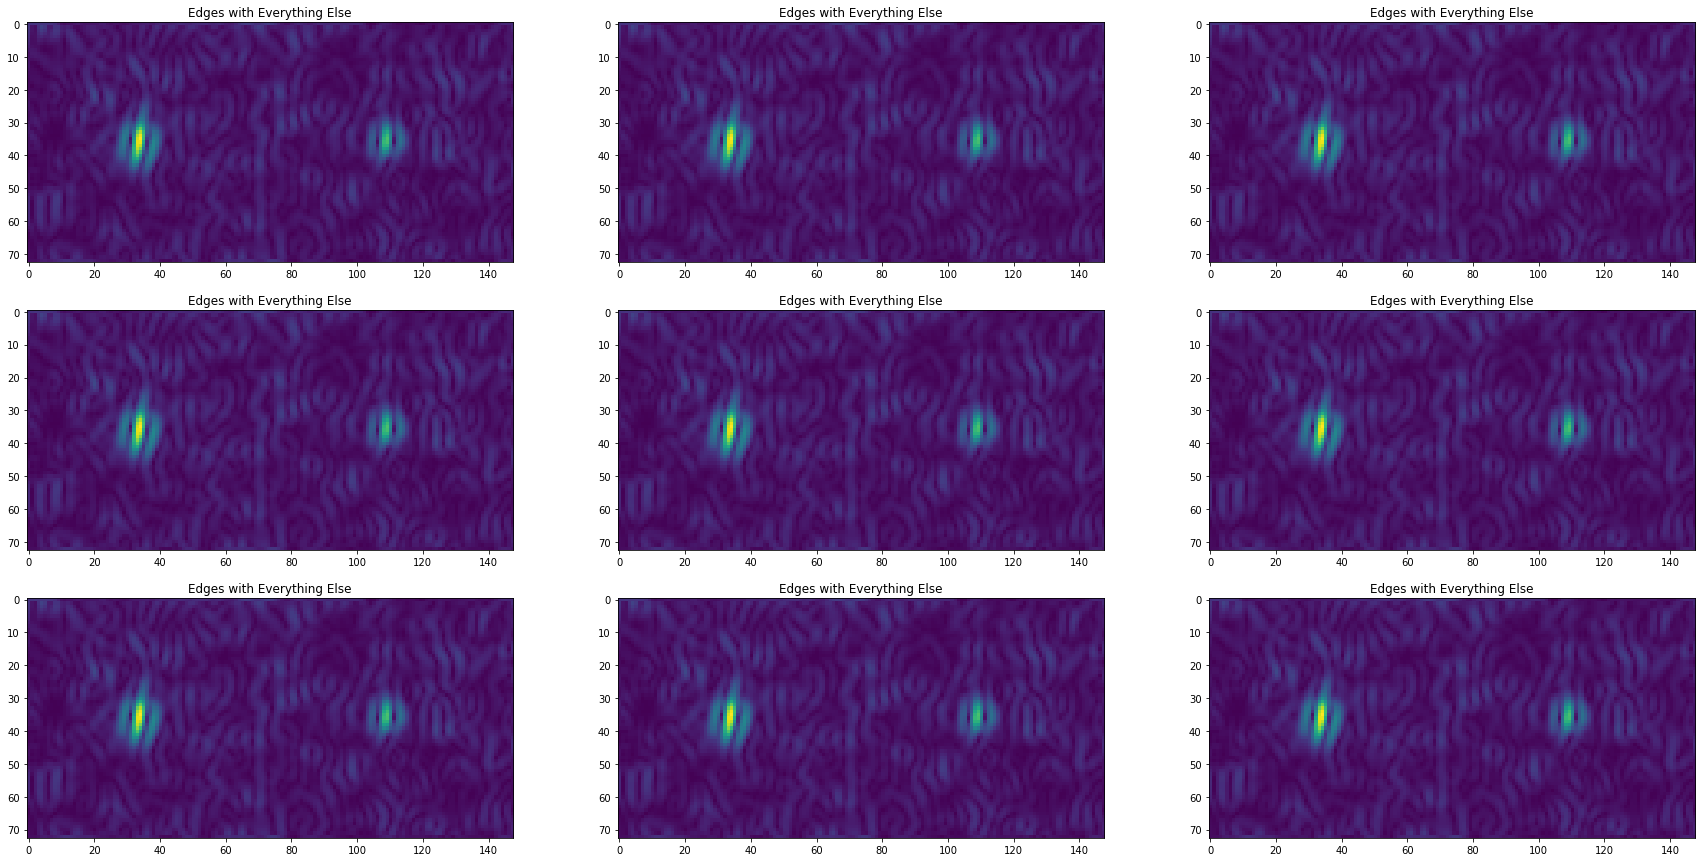

In [147]:
samplePlots(pre_process_edge_et_all(train), "Edges with Everything Else")

In [149]:
def pre_process_abs(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        #gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(concat, xder, mode= 'valid')
        # Append to array
        deriv = np.absolute(deriv)
        imgs.append(deriv)

    return np.array(imgs)

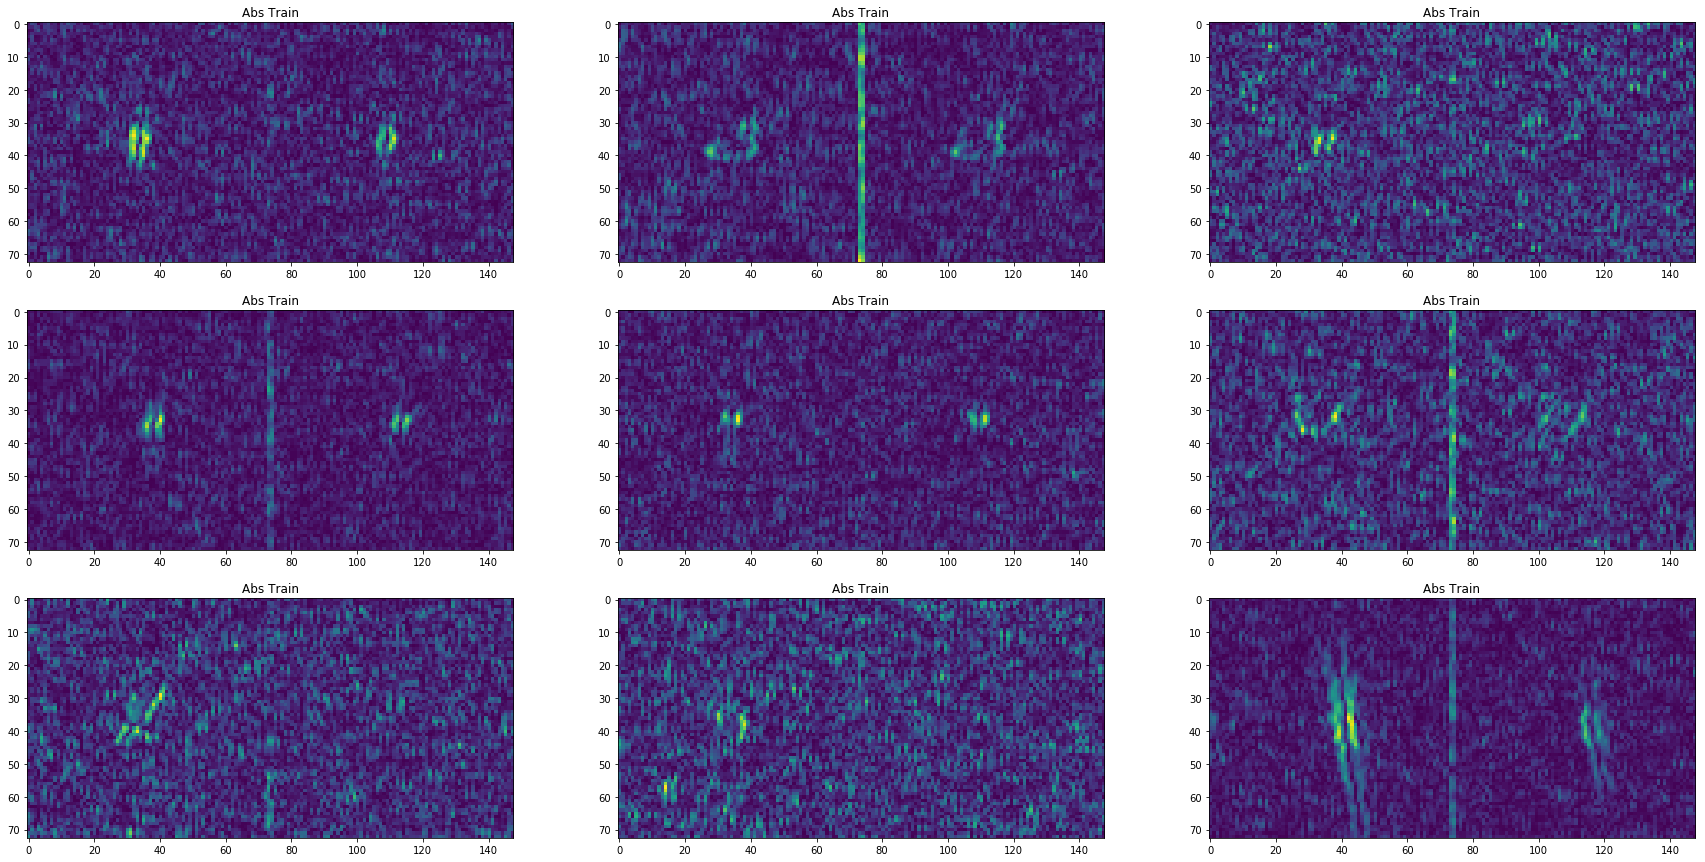

In [150]:
samplePlots(pre_process_abs(train), 'Abs Train')